In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import astropy
import astropy.units as u
from astropy.coordinates import SkyCoord
import os
import numpy as np
import specsim.simulator
from speclite import filters
from speclite import redshift
from astropy.constants import h, c, k_B, sigma_sb
from astropy.cosmology import Planck18
from astropy.table import Table, join
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
import bed
from bed.grid import Grid, PermutationInvariant
from bed.design import ExperimentDesigner
from bed.grid import TopHat
import galsim

# local imports
from lsstetc import ETC
from functions import *

Calculate the integrated band photon flux for a given redshift and band.

In [3]:
F_b(0.05, "g")

<Quantity [0.00882231] 1 / (s cm2)>

To calculate the total photon count given the exposure time, redshift, and band, we use the flux $F_b$ multiplied by the LSST effective area $A$ and the input exposure time which is a function of number of visits $N_v \times t_{exp}$ where $t_{exp}$ is a fixed value of 30 seconds for LSST exposures.

In [4]:
photon_count(60, 0.05, 'i').item()

<Quantity 344918.27359431>

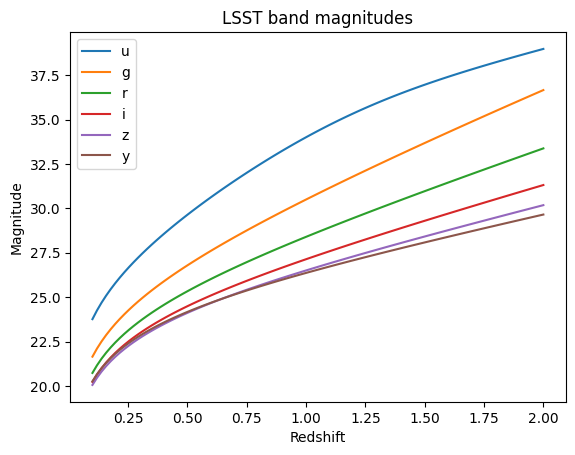

In [5]:
plt.plot(np.linspace(0.1, 2, 100), M_b(np.linspace(0.1, 2, 100), "u"), label = "u")
plt.plot(np.linspace(0.1, 2, 100), M_b(np.linspace(0.1, 2, 100), "g"), label = "g")
plt.plot(np.linspace(0.1, 2, 100), M_b(np.linspace(0.1, 2, 100), "r"), label = "r")
plt.plot(np.linspace(0.1, 2, 100), M_b(np.linspace(0.1, 2, 100), "i"), label = "i")
plt.plot(np.linspace(0.1, 2, 100), M_b(np.linspace(0.1, 2, 100), "z"), label = "z")
plt.plot(np.linspace(0.1, 2, 100), M_b(np.linspace(0.1, 2, 100), "y"), label = "y")
plt.legend()
plt.xlabel("Redshift")
plt.ylabel("Magnitude")
plt.title("LSST band magnitudes")
plt.show()

In [6]:
band = "i"
pixel_scale = 0.2 # arcsec
stamp_size = 31 # pixels
threshold = 0.0 # threshold for masking 
nvisits = 50 # number of visits
visit_time = 30.0
gal = galsim.Gaussian(flux=1.0, sigma=2) # sigma = 2 arcsec
psf = galsim.Gaussian(fwhm=0.67) # Full-width half-max of the PSF in arcseconds

profile = galsim.Convolve([gal, psf])
etc = ETC(band, profile=profile, pixel_scale=pixel_scale, stamp_size=stamp_size,
              threshold=threshold, nvisits=nvisits, visit_time=visit_time)

In [7]:
gal = galsim.Gaussian(flux=photon_count(etc.exptime, 0.05, 'i').item(), sigma=2) # sigma = 2 arcsec
psf = galsim.Gaussian(fwhm=0.67) # Full-width half-max of the PSF in arcseconds

profile = galsim.Convolve([gal, psf])

img = profile.drawImage(scale=pixel_scale)

gd = galsim.GaussianNoise(galsim.BaseDeviate(1), sigma=etc.sigma_sky)
img.addNoise(gd)

In [14]:
def check_noise(band, redshift, nvisits=50, pixel_scale=0.2, stamp_size=31, threshold=0.0, visit_time=30.0):

    gal = galsim.Gaussian(flux=1.0, sigma=1) # sigma = 2 arcsec
    psf = galsim.Gaussian(fwhm=0.67) # Full-width half-max of the PSF in arcseconds

    profile = galsim.Convolve([gal, psf])   
    
    etc = ETC(band, profile=profile, pixel_scale=pixel_scale, stamp_size=stamp_size,
                threshold=threshold, nvisits=nvisits, visit_time=visit_time)

    SNR, signal, noise = etc.SNR(profile, M_b(redshift, band).item())

    A = 319/9.6 # LSST effective area in m^2 from lsstetc.py
    A_cm2 = A * 1e4 * u.cm**2 # convert to cm^2
    total_flux = photon_count(etc.exptime, redshift, band, A_cm2).item()
    img = galsim.ImageD(etc.stamp_size, etc.stamp_size, scale=etc.pixel_scale)
    profile = profile.withFlux(total_flux)
    img = profile.drawImage(image=img) * (img.array > (etc.threshold * etc.sigma_sky))
    vals = []
    for i in range(10000):
        gd = galsim.GaussianNoise(galsim.BaseDeviate(i), sigma=etc.sigma_sky)
        noisy_img = img.copy()
        noisy_img.addNoise(gd)
        vals.append(np.sum(noisy_img.array * img.array * (img.array > (etc.threshold * etc.sigma_sky))))

    bins = np.linspace(np.mean(vals) - 5 * noise, np.mean(vals) + 5 * noise, 51)
    plt.hist(vals, bins=bins, density=True, label="Galsim images with noise")
    w = 0.5 * (bins[1:] + bins[:-1])
    y = np.exp(-0.5 * ((w - signal) / noise) ** 2) / (noise * np.sqrt(2 * np.pi))
    plt.plot(w, y, 'tab:red', label="ETC noise")
    print("Gaussian error", np.mean(vals), np.std(vals))
    plt.xlabel("Weighted Signal")
    plt.title(f"Band: {band}, Redshift: {redshift}")
    plt.legend()
    plt.show()

Gaussian error 218655375871.98026 127233067.32738224


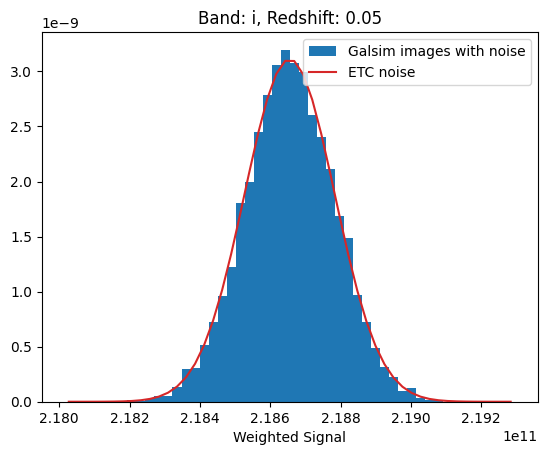

In [15]:
check_noise("i", 0.05)

Gaussian error 530368593.62011415 6266146.460922894


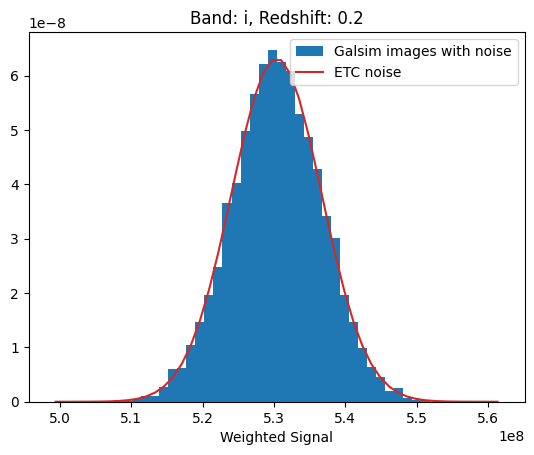

In [16]:
check_noise("i", 0.2)

Gaussian error 4593135.552600087 583089.666484988


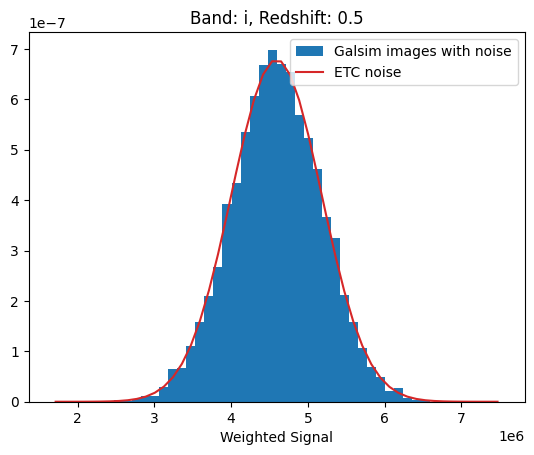

Gaussian error 35289.701965341075 51043.31200876981


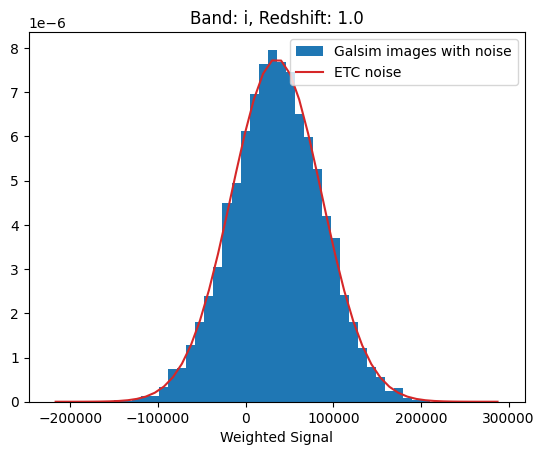

In [17]:
check_noise("i", 0.5)
check_noise("i", 1.0)

In [65]:
M_b(0.05, 'i').item()

18.78332277832162

In [70]:
etc.SNR(profile, M_b(0.05, 'i').item())

10591844118.568516 19956637.184816904


np.float64(530.7429313104333)

In [62]:
np.sqrt(np.var(np.array(vals)))

np.float32(47211810.0)